# Partie II - Evolution temporelle

Ici, on utilise l'algorithme d'Euler explicite pour obtenir l'évolution temporelle de la fonction d'onde. Cet algorithme, bien que simple à utiliser, n'est pas très efficace.

Lors de la partie 1, on utilisait un Hamiltonien à valeurs réelles, ici nous sommes obligés d'utiliser des valeurs complexes.

Imaginons que l'on obtienne un hamiltonien complexe $\psi(x)$ sous la forme d'un array numpy

In [130]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh_tridiagonal
from matplotlib.animation import PillowWriter
from numba import njit
from time import perf_counter

# On définit d'abord les constantes dx et dt.
N = 400
L = 50
dx = L/N

M = 2000
T = 2
dt = T/M
dt_approx = np.format_float_scientific(dt, precision = 1, exp_digits=1)

# Puis x tel que 

x = np.linspace(-L,L,N)

print("dt= ",dt)
print("dx= ",dx)

dt=  0.001
dx=  0.125


On réitère ensuite la formation d'un hamiltionien vu lors de la partie 1 pour un potentiel nul

In [131]:
V_nul = np.zeros(N) #potentiel nul

@njit
def get_matrice(potentiel):
    """
    Return d the diagonal and e the eigh-diagonal of H from a potential
    :param potentiel: potential to give
    :return: d,e diagonal and eigh-diagonal
    """

    d = np.zeros(N)
    e = np.zeros(N-1)

    for i in range(potentiel.size):
        d[i] = 2/(dx**2) + potentiel[i]

    for i in range(e.size):
        e[i] = -1/(dx**2)
        
    return d,e

@njit
def normalize(m, deltax):
    """
    Return the normalized np array, with the boundaries set to 0
    :param m: array to normalize
    :param deltax: the difference betweenn 2 x
    :return: normalized np array
    """
    m /= np.linalg.norm(m)
    m /= np.sqrt(deltax)
    m[0] = 0
    m[-1] = 0
    return m

# On crée la fonction pour former les etats stationnaires à partir de V
def get_psi_statio(potentiel):
    """
    Return (w,v) with w the eigenvalues of H and v eigenvectors
    :param potentiel: potential to find w and v
    :return: (w,v)
    """
    d,e = get_matrice(potentiel) #On récupère la matrice de la formule donné par l'équation (2)

    ## Puis, on calcule w et v respectivement les valeurs propres et vecteurs propres de H
    w, v = eigh_tridiagonal(d,e)
    v0 = np.zeros((N,N))
    for i in range(N):
        for y in range(N):            #On échange ligne et colonnes
            v0[i][y] = v[y][i]
    # On doit désormais normaliser les vecteurs propres :
    for vec in v0:
        normalize(vec,dx)
    return w,v0

Puis, on forme la matrice H complète à partir de ses valeurs tridiagonale

In [132]:
@njit
def get_h(potentiel):
    """
    Return H the matrix from the potential
    :param potentiel: potential to get H
    :return: H matrix (N,N)
    """
    h = np.zeros((N,N))
    d,e = get_matrice(potentiel)
    # on ajoute les valeurs dans H
    for i in range(N):
        h[i][i] += d[i]
        if i != N-1:
            h[i][i+1] += e[i]
            h[i+1][i] += e[i]
    return h

On forme ensuite une liste de liste psi\[t\]\[x\] représentant toutes les valeurs de v (le vecteur de psi) pour tout t

In [133]:
@njit
def f(psi,potentiel):
    """
    The method we get from the fonction of d/dt(psi)
    :param psi: psi
    :param potentiel: potential
    :return: d/dt(psi)
    """
    moins_i_H = (-1j*get_h(potentiel)).astype(np.complex64)
    psi_np = psi.astype(np.complex64)
    return np.dot(moins_i_H,psi_np)

@njit
def euler(psi,potentiel):
    """
    The Euler method
    :param psi: psi
    :param potentiel: potential
    :return: normalized version of Euler of psi
    """
    new_psi = psi + dt*f(psi,potentiel)
    return normalize(new_psi,dx)

Enfin, on utilise la formule (7) du poly ce qui nous donne les valeurs de psi pour différents temps :

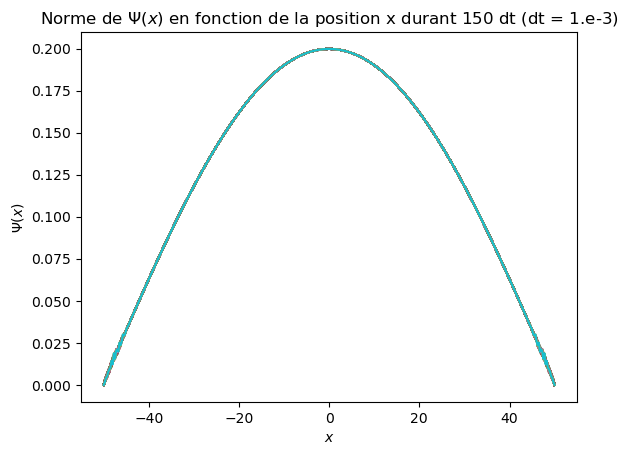

In [134]:
# On crée la fonction pour afficher les graphiques

def get_graph(psi,potentiel,method,name,nb_dt):
    """
    Return final graph, and save with number M, time nb_dt, and a chosen name
    :param psi: initial psi
    :param potentiel: potentiel of situation
    :param method: method for solbing ODE
    :param name: name to put on the graph
    :param nb_dt: number of step to show
    """
    for i in range(nb_dt):
        psi = method(psi,potentiel)
        plt.plot(x,abs(psi),label="Numérique $t=%i \cdot dt$" %i)
    plt.xlabel('$x$')
    plt.ylabel('$\Psi(x)$')
    plt.title('Norme de $\Psi(x)$ en fonction de la position x durant %i dt (dt = %s)' %(nb_dt,dt_approx))
    plt.savefig('docs/tempo/psi_fonction_de_x_%s_m%i_duree_%i.pdf' %(name,M,nb_dt),format='pdf',bbox_inches='tight')
    plt.savefig('docs/tempo/psi_fonction_de_x_%s_m%i_duree_%i.jpeg' %(name,M,nb_dt),format='jpeg',bbox_inches='tight')
    plt.show()

w_test,v_test = get_psi_statio(V_nul)
psi0 = v_test[0] #Première harmonique
get_graph(psi0,V_nul,euler,"euler_etat_statio0",150)

Ici, nous allons reprendre le même processus mais avec un état initial sous forme d'un paquet d'onde d'une gaussienne

In [135]:
def get_psi_gauss(x0,sigma,k):
    """
    Get the Psi0 in a form of a gaussian wave paquet
    :param x0: X where the gaussian is maximal
    :param sigma: how large is the gaussian
    :param k: wave vector
    :return: psi0
    """
    psi = np.zeros(N,dtype=complex)

    for i in range(N):
        inside_exp = -((x[i]-x0)**2)*(sigma**2)/4
        psi[i] = np.exp(inside_exp)/(sigma*np.sqrt(2*np.pi))*sigma**(3/2)
        psi[i] *= np.exp(1j*k*x[i])
    psi = normalize(psi,dx)
    return psi

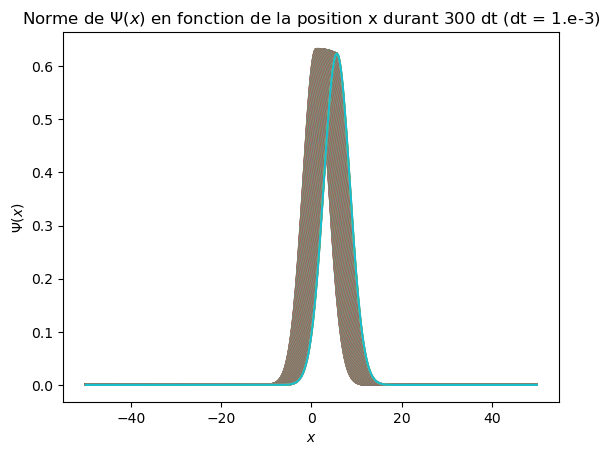

In [136]:
get_graph(get_psi_gauss(1,0.5,2),V_nul,euler,"euler_gaussienne",300)

On remarque ici que notre rendu n'est pas correct, ou alors est trop long. En effet l'algorithme d'Euler explicite ne nous permet pas d'être suffisament précis, nous allons donc mettre en oeuvre l'algorithme de Runge-Kutta d'ordre 4

In [137]:
@njit
def rk4(psi,potentiel):
    """
    RK4 method
    :param psi: psi
    :param potentiel: potential
    :return: rk4 of psi
    """
    k1 = f(psi,potentiel)
    k2 = f(psi + k1 * dt / 2.,potentiel)
    k3 = f(psi + k2 * dt / 2.,potentiel)
    k4 = f(psi + k3 * dt,potentiel)
    new_psi = psi + (dt / 6.)*(k1 + 2*k2 + 2*k3 + k4)
    new_psi = new_psi.astype(np.complex64)
    return normalize(new_psi,dx)

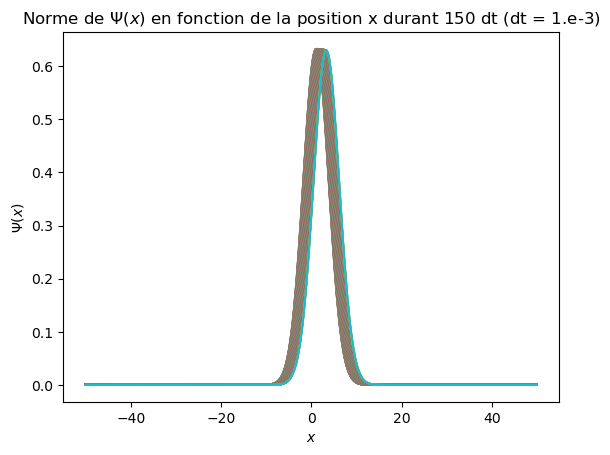

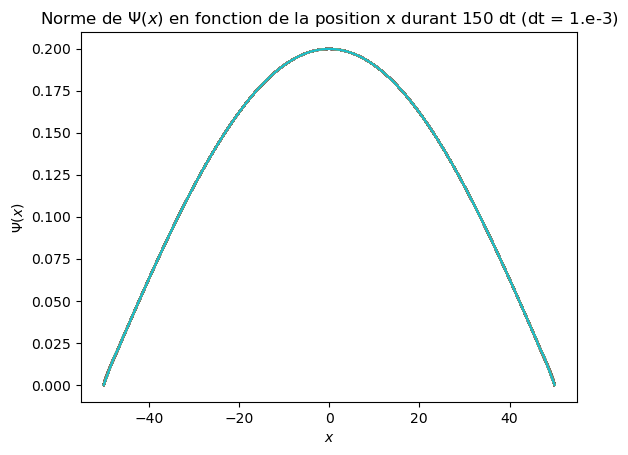

In [138]:
get_graph(get_psi_gauss(1,0.5,2),V_nul,rk4,"rk4_gaussienne",150)
get_graph(psi0,V_nul,rk4,"rk4_etat_statio0",150)

In [139]:
# ------------ ANIMATION -------------- #
def get_anim_diff_between_methods(psi_init_1,psi_init_2,potentiel,xmax,final_time,step,name,print_pot):
    """
    Save a gif named anim_RK4 with a specific name that compare euler and RK4
    :param xmax: get the graph to plot from -xmax to xmax
    :param final_time: Final t to get the animation
    :param psi_init_1: Initial psi for RK4
    :param psi_init_2: Initial psi for Euler
    :param potentiel: Total potential
    :param step: save a image each [step] itérations
    :param name: name to add to the file
    :param print_pot: boolean - true if you want the potential to be on the graph
    """

    start = perf_counter()

    metadata = dict(title='test', artist='lucas')
    writer = PillowWriter(fps=60, metadata=metadata)

    fig = plt.figure()
    plt.xlim(-xmax, xmax)
    plt.ylim(-0.5, 2)

    t = 0
    t_approx = np.format_float_scientific(t, precision = 2, exp_digits=1)

    plt.xlabel('$x$')
    plt.ylabel('$\\Psi(x)$')
    plt.title('Norme de $\\Psi(x)$ en fonction de la position x (t = %s)' % t_approx)

    if print_pot:
        pot, = plt.plot(x,potentiel,linestyle='dotted',label="Potentiel")

    l, = plt.plot(x,abs(psi_init_1),label="RK4")
    l2, = plt.plot(x,abs(psi_init_2), label="Euler")

    plt.legend()

    new_psi1 = psi_init_1
    new_psi2 = psi_init_2

    with writer.saving(fig, "docs/tempo/anim_%s_M_%s.gif"%(name,M), 100):
        for i in range(final_time):
            new_psi1 = rk4(new_psi1,potentiel)
            new_psi2 = euler(new_psi2,potentiel)

            t += dt

            if i%step == 0:

                l.set_data(x,abs(new_psi1))
                l2.set_data(x,abs(new_psi2))

                t_approx = np.format_float_scientific(t, precision = 2, exp_digits=1)
                plt.title('Norme de $\\Psi(x)$ en fonction de la position x (t = %s) pour un dt=%s' % (t_approx,dt_approx))

                writer.grab_frame()
    plt.show()

    end = perf_counter()
    print("Elapsed (after compilation) = {}s".format((end - start)))
# ------------ FIN ANIMATION -------------- #

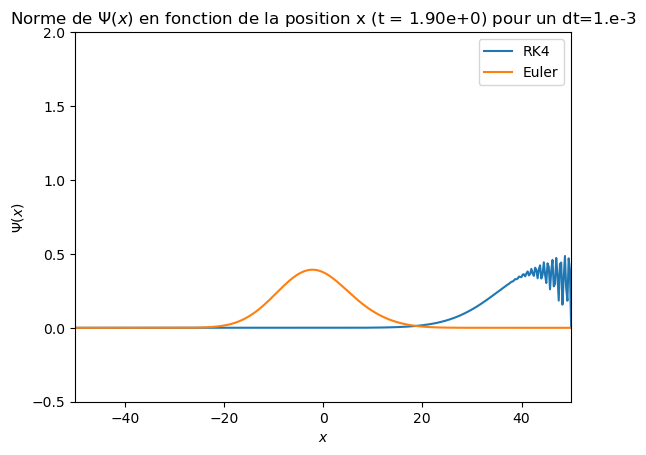

Elapsed (after compilation) = 10.188323699999955s


In [140]:
get_anim_diff_between_methods(get_psi_gauss(1,1,3),get_psi_gauss(-1,1,-3),V_nul,L,M,100,"gauss_pot_nul_séparé",False)

On va maintenant essayer de former un vecteur d'état initial étant une combinaison d'états stationnaires puis voir la différence entre le résultat numérique et théorique

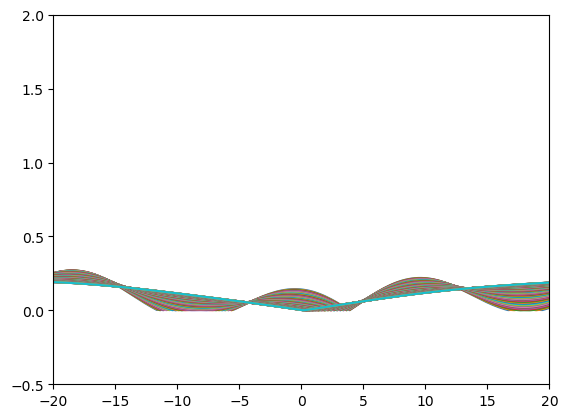

In [141]:
w_nul,v_nul = get_psi_statio(V_nul)

def get_sum_vect_initial(eigenvectors,dict_vect):
    """
    Return a vector made of harmonics of the potential (stationary states)
    :param eigenvectors: stationary state array
    :param dict_vect: dictionary of sum for the final vect ( Ex : {0:1,2:3} -> 1*v[0] + 3*v[2] )
    :return: sum of stationary states given by the dictionary dict_vect
    """
    final_v = np.zeros(N)
    for p,val in dict_vect.items():
        final_v += eigenvectors[p]*val
    return final_v

def theorical_time_passing(eigenvectors,eigenvalues,dict_vect,t):
    """
    Return the new vector for the t value
    :param eigenvectors: stationary state array
    :param eigenvalues: stationary state value of energy
    :param dict_vect: dictionary of sum for the final vect ( Ex : {0:1,2:3} -> 1*v[0] + 3*v[2] )
    :param t: value of time
    :return: Return the new vector for the t value
    """
    psi = np.zeros(N)
    for p,val in dict_vect.items():
        psi += val*eigenvectors[p]*np.exp(-eigenvalues[p]*t)
        psi = psi.astype(np.complex64)
    return normalize(psi,dx)

plt.xlim(-20, 20)
plt.ylim(-0.5, 2)
for i in range(100):
    plt.plot(x,abs(theorical_time_passing(v_nul,w_nul,{1:10,10:10},i/10)))
plt.show()

In [142]:
# ------------ ANIMATION -------------- #
def get_anim_diff_theorical_with_statio(dict_statio,eigenvalues,eigenvectors,method_theorical,potentiel,xmax,final_time,step,name,print_pot):
    """

    Save a gif with a specific name that compare RK4 and theorical sum of stationnary states with time
    :param method_theorical: method to get the theorical value
    :param eigenvectors: stationary state array
    :param eigenvalues: stationary state value of energy
    :param dict_statio: dictionary of sum for the final vect ( Ex : {0:1,2:3} -> 1*v[0] + 3*v[2] )
    :param xmax: get the limits of the graph to plot
    :param final_time: Final t to get the animation
    :param potentiel: Total potential
    :param step: save a image each [step] itérations
    :param name: name to add to the file
    :param print_pot: boolean - true if you want the potential to be on the graph
    """

    start = perf_counter()

    metadata = dict(title='test', artist='lucas')
    writer = PillowWriter(fps=60, metadata=metadata)

    fig = plt.figure()
    plt.xlim(-xmax, xmax)
    plt.ylim(0, 0.2)

    t = 0
    t_approx = np.format_float_scientific(t, precision = 2, exp_digits=1)

    plt.xlabel('$x$')
    plt.ylabel('$\\Psi(x)$')
    plt.title('Norme de $\\Psi(x)$ en fonction de la position x (t = %s)' % t_approx)

    if print_pot:
        pot, = plt.plot(x,potentiel,label="Potentiel")

    l, = plt.plot(x,abs(get_sum_vect_initial(eigenvectors,dict_statio))**2,label="RK4")
    l2, = plt.plot(x,abs(get_sum_vect_initial(eigenvectors,dict_statio))**2, label="Theorical")

    plt.legend()

    new_psi1 = get_sum_vect_initial(eigenvectors,dict_statio).astype(np.complex64)

    with writer.saving(fig, "docs/tempo/anim_%s.gif"%name, 100):
        for i in range(final_time):

            t += dt

            new_psi1 = rk4(new_psi1,potentiel)
            new_psi2 = method_theorical(eigenvectors,eigenvalues,dict_statio,t)

            if i%step == 0:

                l.set_data(x,abs(new_psi1))
                l2.set_data(x,abs(new_psi2))

                t_approx = np.format_float_scientific(t, precision = 2, exp_digits=1)
                plt.title('Norme de $\\Psi(x)$ en fonction de la position x (t = %s) pour un dt=%s' % (t_approx,dt_approx))

                writer.grab_frame()
    plt.savefig('docs/tempo/somme_statio_5000.png',format='png',bbox_inches='tight')
    plt.show()
    end = perf_counter()
    print("Elapsed (after compilation) = {}s".format((end - start)))
# ------------ FIN ANIMATION -------------- #

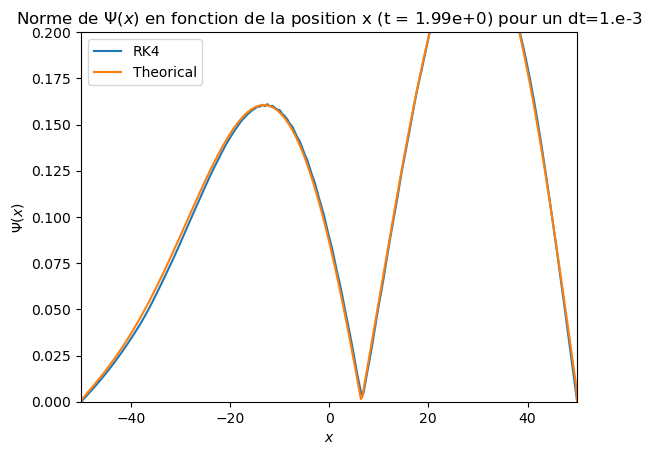

Elapsed (after compilation) = 12.355414200000041s


In [143]:
get_anim_diff_theorical_with_statio({1:2,2:1},w_nul,v_nul,theorical_time_passing,V_nul,L,M,10,"stationnaire_diff_theorical2",False)

Prenons désormais un potentiel harmonique puis un potentiel sous forme de double puit harmonique

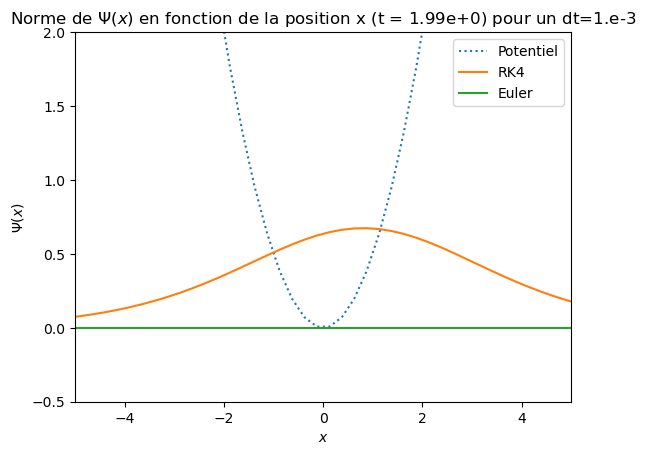

Elapsed (after compilation) = 13.661965900000041s


In [144]:
def get_pot_harmonique(omega):
    """
    Return an array for a harmonic potential
    :param omega: the value of omega in the harmonic potential
    :return: Numpy Array
    """
    pot_harmo = np.zeros(N)
    for i in range(N):
        pot_harmo[i] = (omega**2 * x[i]**2) / 2
    return pot_harmo

get_anim_diff_between_methods(get_psi_gauss(1,2,0),get_psi_gauss(1,2,0),get_pot_harmonique(1),5,M,10,"gauss_potentiel_harmo_identique",True)

In [145]:
def get_pot_double_puit(x0,omega):
    """
    Return an array for a double barrier potential from a to b with val value
    :param x0: value of x0 in the harmonic
    :param omega: value of omega in the harmonic
    :return: Numpy Array
    """
    pot_db_puit = np.zeros(N)
    for i in range(N):
        if x[i]<0:
            pot_db_puit[i] = (omega**2 * (x[i]+x0)**2) / 2
        else:
            pot_db_puit[i] = (omega**2 * (x[i]-x0)**2) / 2
    return pot_db_puit

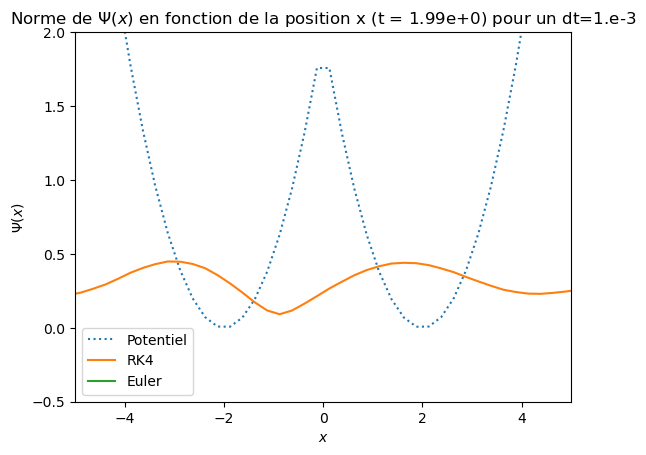

Elapsed (after compilation) = 14.453612700000122s


In [146]:
get_anim_diff_between_methods(get_psi_gauss(-2,4,0),np.zeros(N),get_pot_double_puit(2,1),5,M,10,"gauss_potentiel_double_puit",True)

### Sources :
 - https://www.f-legrand.fr/scidoc/docmml/numerique/euler/euler/euler.html
 - https://www.youtube.com/watch?v=tsK72kSgPoI
 - https://www.moonbooks.org/Articles/How-to-create-a-matrix-of-complex-numbers-in-python-using-numpy-/
 - https://femto-physique.fr/analyse-numerique/runge-kutta.php
 - https://numba.readthedocs.io/en/stable/user/5minguide.html#will-numba-work-for-my-code